# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sns

sns.set_style("darkgrid")
%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
print(f"Number of articles: {df.shape[0]}")

Number of articles: 45993


In [4]:
print(f"Content dataframe shape: {df_content.shape}")

Content dataframe shape: (1056, 5)


In [5]:
article_interactions = df[['article_id','email']].groupby('email').count().sort_values(by='article_id',ascending=False)

In [6]:
print(f"Min number of interactions with an article: {article_interactions.min()[0]}")
print(f"Max number of interactions with an article: {article_interactions.max()[0]}")
print(f"Mean number of interactions with an article: {article_interactions.mean()[0]}")

Min number of interactions with an article: 1
Max number of interactions with an article: 364
Mean number of interactions with an article: 8.930846930846931


In [7]:
def plot_iteractions_distribution(df):
    plt.figure(figsize=(10, 6))
    plt.hist(df[['article_id','email']].groupby('email').count()['article_id'],
             bins=100,
            color='darkmagenta');
    plt.xlim(right=100)
    plt.xlim(left=0)
    plt.xticks(fontsize=14,fontweight='bold')
    plt.yticks(fontsize=14,fontweight='bold')
    plt.xlabel("Number of Interactions", fontsize=16, fontweight='bold')
    plt.ylabel("Number of occurrences", fontsize=16, fontweight='bold')
    plt.title("Distribution of The Number of Interactions", fontsize=20, fontweight='bold')

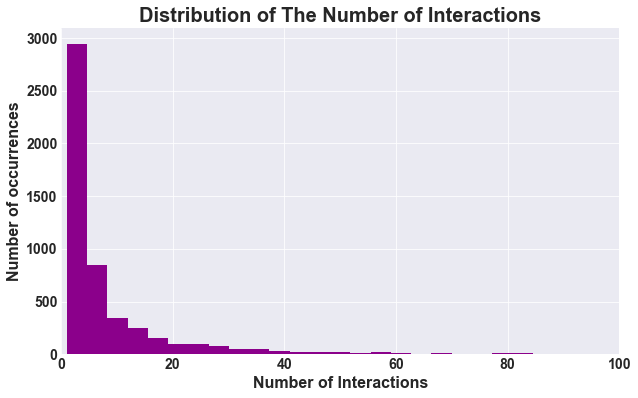

In [8]:
plot_iteractions_distribution(df)

In [9]:
print(f"Number of unique users: {df['email'].nunique()}")

Number of unique users: 5148


In [10]:
# Fill in the median and maximum number of user_article interactios below

median_val = article_interactions.median()[0]# 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = article_interactions.max()[0]# The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [11]:
# Find and explore duplicate articles
for column in list(df_content.columns):
    duplicateds = df_content.duplicated(subset=column).sum()
    print(f"Number of duplicated rows in column {column}: {duplicateds}")

Number of duplicated rows in column doc_body: 19
Number of duplicated rows in column doc_description: 33
Number of duplicated rows in column doc_full_name: 5
Number of duplicated rows in column doc_status: 1055
Number of duplicated rows in column article_id: 5


In [12]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id',keep='first',inplace=True)

In [13]:
for column in list(df_content.columns):
    duplicateds = df_content.duplicated(subset=column).sum()
    print(f"Number of duplicated rows in column {column}: {duplicateds}")

Number of duplicated rows in column doc_body: 19
Number of duplicated rows in column doc_description: 31
Number of duplicated rows in column doc_full_name: 0
Number of duplicated rows in column doc_status: 1050
Number of duplicated rows in column article_id: 0


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [14]:
print(f"Number of unique articles that have user interaction: {df['article_id'].nunique()}")
print(f"Number of unique articles: {df_content['article_id'].nunique()}")
print(f"Number of unique users: {df[~df.isnull()]['email'].nunique()}")
print(f"Number of user-article interactions: {df.shape[0]}")

Number of unique articles that have user interaction: 714
Number of unique articles: 1051
Number of unique users: 5148
Number of user-article interactions: 45993


In [15]:
unique_articles = df['article_id'].nunique()# The number of unique articles that have at least one interaction
total_articles = df_content['article_id'].nunique()# The number of unique articles on the IBM platform
unique_users = df[~df.isnull()]['email'].nunique()# The number of unique users
user_article_interactions = df.shape[0]# The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [16]:
max_views = df.groupby('article_id')['email'].count().sort_values(ascending=False).values[0]
most_viewed_article_id = df.groupby('article_id')['email'].count().sort_values(ascending=False).index[0]

In [17]:
print(f"The most viwed article was the one with ID {most_viewed_article_id}.\
        The number of views were: {max_views} users")

The most viwed article was the one with ID 1429.0.        The number of views were: 937 users


In [18]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [19]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': str(most_viewed_article_id),
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [20]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    article_interactions = df.groupby(['article_id','title'])['user_id'].count().reset_index()
    article_interactions = article_interactions.sort_values(by='user_id',ascending=False).head(n)
    
    top_articles = list(article_interactions['title'])
  
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.groupby('article_id')['user_id'].count().sort_values(ascending=False).head(n).index
    top_articles = list(top_articles)
    
    return top_articles # Return the top article ids

In [21]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [22]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [23]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.groupby(['user_id','article_id'])['title'].count().unstack()
    user_item = user_item.fillna(0)
    user_item = user_item.applymap(lambda x: 1 if x >= 1 else 0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [24]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [25]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_ids = np.array(user_item.index)
    user_idx = np.where(np.array(user_item.index)==user_id)[0][0]
    
    #Dot product to find similarities
    user_similarities = np.dot(user_item.values,user_item.values[user_idx,:])

    # sort by similarity
    most_similar_idxs = np.argsort(user_similarities)[::-1]
    user_idx = np.where(most_similar_idxs==user_idx)[0][0]
    
    # remove the own user's id
    most_similar_users = np.delete(user_ids[most_similar_idxs],user_idx,axis=0)
    
    return most_similar_users # return a list of the users in order from most to least similar

In [26]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933   23 3782  203 4459  131 3870   46 4201 5041]
The 5 most similar users to user 3933 are: [   1   23 3782 4459  203]
The 3 most similar users to user 46 are: [4201   23 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [212]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []
    
    unique_articles_df = df.groupby(['article_id','title']).count().reset_index()[['article_id','title']]
    all_article_ids = unique_articles_df['article_id'].values
    all_article_titles = unique_articles_df['title'].values

    for article_id in article_ids:
        article_idx = np.where(all_article_ids==float(article_id))[0]
        article_names.append(all_article_titles[article_idx][0])
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    user_ids = np.array(user_item.index)
    user_idx = np.where(user_ids==user_id)[0][0]
    
    articles_ids = np.array(user_item.columns)
    
    user_interactions = user_item.values[user_idx,:]
    user_interactions = np.where(user_interactions > 0)
    
    article_ids = articles_ids[user_interactions]
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    current_user_article_ids, _ = get_user_articles(user_id)
    similar_users_arr = find_similar_users(user_id)
    recs = np.array([])

    n_iter = 0
    for similar_user in similar_users_arr:
        n_iter+=1

        article_ids, _ = get_user_articles(similar_user)
        new_recs_ids = np.setdiff1d(np.array(article_ids), np.array(current_user_article_ids))
        recs = np.append(recs,new_recs_ids)

        if len(recs) >= m:
            recs = recs[:m]
            break
    
    recs = list(recs)
    
    return recs # return your recommendations for this user_id    

In [213]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

In [214]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320.0, 232.0, 844.0])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024.0, 1176.0, 1305.0, 1314.0, 1422.0, 1427.0])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [250]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
   
    # compute similarity of each user to the provided user
    user_ids = np.array(user_item.index)
    user_idx = np.where(np.array(user_item.index)==user_id)[0][0]
    
    #Dot product to find similarities
    user_similarities = np.dot(user_item.values,user_item.values[user_idx,:])

    # sort by similarity
    most_similar_idxs = np.argsort(user_similarities)[::-1]
    user_idx = np.where(most_similar_idxs==user_idx)[0][0]
    
    # remove the own user's id
    most_similar_users = np.delete(user_ids[most_similar_idxs],user_idx,axis=0)
    similarities = np.delete(user_similarities[most_similar_idxs],user_idx,axis=0)
    
    #Create Dataframe
    neighbors_df = pd.DataFrame()
    neighbors_df['neighbor_id'] = most_similar_users
    neighbors_df['similarity'] = similarities
    
    #Number of Iteractions
    user_iteractions = df.groupby('user_id')['article_id'].nunique().\
                       reset_index().rename(columns={'article_id':'num_interactions'})
    neighbors_df = neighbors_df.merge(user_iteractions,
                                      left_on='neighbor_id',
                                      right_on='user_id',
                                      how='inner').drop(columns='user_id')
    
    #Sort Values
    neighbors_df = neighbors_df.sort_values(by=['similarity','num_interactions'],ascending=[False,False])
    
    return neighbors_df
    
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    current_user_article_ids, _ = get_user_articles(user_id)
    neighbors_df = get_top_sorted_users(user_id)
    similar_users_arr = neighbors_df['neighbor_id'].values
    recs = np.array([])


    for similar_user in similar_users_arr:
   
        article_ids, _ = get_user_articles(similar_user)
        new_recs_ids = np.setdiff1d(np.array(article_ids), np.array(current_user_article_ids), assume_unique=True)
        recs = np.append(recs,new_recs_ids)

        if len(recs) >= m:
            recs = recs[:m]
            break
    
    recs = list(recs)
    rec_names = get_article_names(recs,df)
    
    return recs, rec_names

In [251]:
user_user_recs_part2(1)

([2.0, 12.0, 14.0, 16.0, 26.0, 28.0, 29.0, 33.0, 50.0, 74.0],
 ['this week in data science (april 18, 2017)',
  'timeseries data analysis of iot events by using jupyter notebook',
  'got zip code data? prep it for analytics. – ibm watson data lab – medium',
  'higher-order logistic regression for large datasets',
  'using machine learning to predict parking difficulty',
  'deep forest: towards an alternative to deep neural networks',
  'experience iot with coursera',
  'using brunel in ipython/jupyter notebooks',
  'graph-based machine learning',
  'the 3 kinds of context: machine learning and the art of the frame'])

In [252]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[12.0, 14.0, 29.0, 33.0, 43.0, 51.0, 109.0, 111.0, 130.0, 142.0]

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'got zip code data? prep it for analytics. – ibm watson data lab – medium', 'experience iot with coursera', 'using brunel in ipython/jupyter notebooks', 'deep learning with tensorflow course by big data university', 'modern machine learning algorithms', 'tensorflow quick tips', 'tidy up your jupyter notebooks with scripts', "feature importance and why it's important", 'neural networks for beginners: popular types and applications']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [272]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0,0]# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[10,0]# Find the 10th most similar user to user 131

In [273]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

### Predictions for New User:

#### Making predictions for a new user, which means we don't have data about it, is called the Cold Start Problem. We could follow some different approaches to solve this problem:

- We could make an content-based recommendation system based on the very first interactions of the user. In this case, we could for example make an NLP and use a text-similarity base recommender.

- Another approach, which was the one used in the following exercise, is to just recommend the most famous item, i.e, the article with the higher number of interactions.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [278]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)

In [280]:
get_top_article_ids(10)

[1429.0,
 1330.0,
 1431.0,
 1427.0,
 1364.0,
 1314.0,
 1293.0,
 1170.0,
 1162.0,
 1304.0]

In [281]:
assert set(new_user_recs) == set([1314.0,1429.0,1293.0,1427.0,1162.0,1364.0,1304.0,1170.0,1431.0,1330.0]), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [285]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [283]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [286]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)

In [287]:
s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

**Provide your response here.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

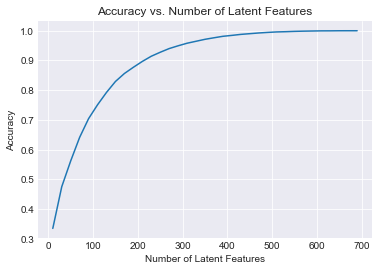

In [288]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [519]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    #Create User-Item Matrix For Training and Testing Data
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    #Obtain the corresponding IDs
    test_idx = list(user_item_test.index)
    test_arts = list(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [499]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

In [500]:
train_user_ids = list(user_item_train.index)
print(f"Number of users we can make predictions for: {len(intersection(train_user_ids,test_idx))}")

Number of users we can make predictions for: 20


In [501]:
print(f"Number of new users (cold start problem): {len(test_idx)-len(intersection(train_user_ids,test_idx))}")

Number of new users (cold start problem): 662


In [502]:
train_article_ids = list(user_item_train.columns)
print(f"Number of articles we can make predictions for: {len(intersection(train_article_ids,test_arts))}")

Number of articles we can make predictions for: 574


In [503]:
print(f"Number of new articles (cold start problem): {len(test_arts)-len(intersection(train_article_ids,test_arts))}")

Number of new articles (cold start problem): 0


In [504]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
    }

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [520]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [521]:
s_train.shape, u_train.shape, vt_train.shape

((714,), (4487, 4487), (714, 714))

#### Subset of rows in the user_item_test dataset that we can use to predict

In [522]:
common_idx = np.intersect1d(user_item_train.index, test_idx)
common_arts = np.intersect1d(user_item_train.columns, test_arts)

In [534]:
print(f"Number of Users we are able to predict: {len(common_idx)}")
print(f"Number of Articles we are able to predict: {len(common_arts)}")

Number of Users we are able to predict: 20
Number of Articles we are able to predict: 574


#### Isolate U, and Vt matrices for making predictions for the indexes we can predict

In [523]:
user_idx_train = user_item_train.index.isin(common_idx)
article_idx_train = user_item_train.columns.isin(common_arts)

u_train, vt_train = u_train[user_idx_train,:] , vt_train[:,article_idx_train]

In [540]:
print(f"Shape of U_train: {u_train.shape}")
print(f"Shape of Vt_train: {vt_train.shape}")
print(f"Shape of S_train: {s_train.shape}")

Shape of U_train: (20, 4487)
Shape of Vt_train: (714, 574)
Shape of S_train: (714,)


#### Select values from user_item_test that we will be predicting

In [524]:
user_idx_test = user_item_test.index.isin(common_idx)
article_idx_test = user_item_test.columns.isin(common_arts)

In [525]:
user_item_test = user_item_test.values[user_idx_test,:][:,article_idx_test]

In [541]:
print(f"Shape of testing matrix: {user_item_test.shape}")

Shape of testing matrix: (20, 574)


#### Make Prediction for the common indexes and store the error

In [542]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
def call_svd_metrics(num_latent_feats):
    """
    This function uses the u_train, s_train and vt_train matrices to make
    predictions. Predictions are then compared to the testing matrix and
    the sum of the absolute errors are computed.
    
    Arguments:
        num_latent_feats: the desired number of latent features
    
    Output:
        sum_errs: the sum of the absolute erros
    """
    sum_errs = []

    for k in num_latent_feats:
        # restructure with k latent features
        s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]

        # take dot product
        user_item_est = np.around(np.dot(np.dot(u_new,s_new),vt_new))

        # compute error for each prediction to actual value
        diffs = np.subtract(user_item_est,user_item_test)
        
        # total errors and keep track of them
        err = np.sum(np.sum(np.abs(diffs)))
        sum_errs.append(err)
    
    return sum_errs

In [543]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = call_svd_metrics(num_latent_feats)

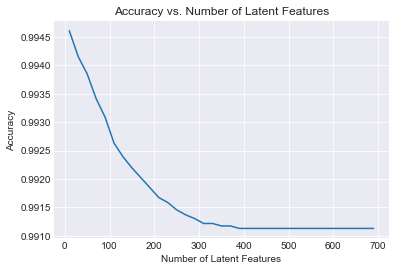

In [544]:
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

### Comments and Conclusions

The resulting cross-validation accuracy is kind of surprising! The model was able to predict a brand new data (testing data) with quite a good accuracy. However, this is also because of the fact that the data is very sparse. Therefore, increasing the number of latent feature basically **overfits** the data, which results in too high metrics for both the training and testing data.

Based on the whole process developed through this jupyter notebook I would like to point out that definetly there isn't a unique and a best way to make recommendations. Although using SVD can result in good metrics, meaning we can predict if a user would interact with an article or not, that doesn't mean this user would actually enjoy the recommended article. Moreover, because usually the data for recommendations is very sparse, a good SVD result can lead to wrong conclusions.

Furthermore, using an algorithm such as SVD don't allow us to directly measure important metrics such as diversity, Novelty and Serendipity. Therefore, It seems that a good approach is to try several algorithms and also a combination of them. For example, one could use content-based algorithms to deal with the **Cold Start** problem and suggest the top 5 itens from one algorithm (such as SVD) and the top 5 itens from another algorithm (such as Similarity-based recommenders).

In order to evaluate which combination of algorithms best match one needs, first it must be very clear what is the final goal. Based on the desired goal, one can define the appropriate metrics that can be used to evaluate the recommendation system. For example, maybe the a good metric is to evaluate if the engine increases the clock through rate. Nevertheless, once a target is defined, we can first evaluate our model through a cross-validation process that can include usual Machine Learning metrics such as RMSE (in the case of SVD) or some more abstract metrics such as hit-rate and diversity.

Once a satisfactory result is reached, the resulting model must be followed by some **Experimental Design**, such as an A/B test that matches the desired goal. The best engine will then be a result of several tests and evaluations.

In [545]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0